In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import os,re
import dateutil.parser as dateparser

#os.chdir(r'C:\Users\*\Desktop\Python Scripts\FB');os.getcwd()
soup = BeautifulSoup(open('messages.htm').read(), "lxml") # FB

In [42]:
# Facebook Activities
tx=[];date=[];user=[]
conv=soup.findAll('div',class_="thread")
for item in conv:
    tx.append([i.text.encode("utf-8") for i in item.findAll('p')])
    date.append([i.text.encode("utf-8") for i in item.findAll('span',class_='meta')])
    user.append([i.text.encode("utf-8") for i in item.findAll('span',class_='user')])
tx =[item for sublist in tx for item in sublist]  # Texts
date=[item for sublist in date for item in sublist] # Dates
user=[item for sublist in user for item in sublist] # Users
shdt=[dateparser.parse(item).strftime('%Y-%m-%d') for item in date] # Changing dates
date=[dateparser.parse(item).strftime('%Y-%m-%d %H:%M') for item in date] # Changing dates
FM=len(tx) # total number of FB messages
FC=len(conv) # total number of FB conversations/threads
print "Facebook Activities"
print "FB Messages:", FM, ":  FB Conversations:", FC

Facebook Activities
FB Messages: 271684 :  FB Conversations: 556


In [4]:
""" Calculating number of calls if you and your friends FB languages are English, Italian or Russian
    1) You can review actual call messages to ensure that they are correct by looking at y,r,z,w variables
    2) Not very accurate because can include also messages which contain those words but you should check step 1) ."""
your_name=raw_input("Enter your FB name:")
a=[your_name,"called"]; b=[your_name,"missed"]; e=[your_name,"persa"]
c=[" called "+your_name,"ha chiamato "+your_name]; d=["missed "+your_name,"perso "+your_name];
call=[] ;f=[]; h=[]
for i in tx:
    if all(x in i for x in a):  call.append("FB Call");f.append(i)
    elif all(x in i for x in b):call.append("FB Call");f.append(i)
    elif any(x in i for x in c):call.append("FB Call");f.append(i)
    elif any(x in i for x in d):call.append("FB Call");f.append(i)
    elif all(x in i for x in e):call.append("FB Call");f.append(i)
    elif "позвонила" in i:      call.append("FB Call");f.append(i) #Called in Russian
    elif "позвонил" in i:       call.append("FB Call");f.append(i) #Called in Russian
    elif "пропустил" in i:      call.append("FB Call");f.append(i) #Missed in Russian
    elif "пропустила" in i:      call.append("FB Call");f.append(i) #Missed in Russian
    else:                       call.append("FB Msg");h.append(i)
#Calculating number of calls for you and other persons
me=[x for x in f if x.startswith(your_name)==True]
no=[x for x in f if x.startswith(your_name)!=True]
y=[];r=[];z=[];w=[]
for i in me:
    if   all(x in i for x in a):  y.append(i) # number of times you called
    else:                         r.append(i) # number of times you missed
for i in no:
    if any(x in i for x in c):    z.append(i) # number of times others called
    elif "позвонила" in i:        z.append(i) # number of times others called in Russian
    else:                         w.append(i) # number of times others missed
YC=len(y) # You called
YM=len(r) # You missed
OC=len(z) # Others called
OM=len(w) # Others missed
TO=len(y)+len(r)+len(z)+len(w)
print "Total number of calls: ", TO
print "You called:",YC," You missed:", YM, "| Others called:",OC,"Others missed:",OM

Enter your FB name:
Total number of calls:  3064
You called: 923  You missed: 420 | Others called: 1206 Others missed: 515


In [5]:
""" See your most used words in your FB messages"""
et=[[i[1]] for i in [list(i) for i in zip(call,tx)] if i[0]=="FB Msg"]
dd = re.sub(r'[?|$|.|!|,]',r''," ".join(e[0] for e in et)).lower()
counts = dict()
for word in dd.rsplit(): counts[word] = counts.get(word,0) + 1
bigcount = None;bigword = None
for word,count in counts.items():
    if bigcount == None or count > bigcount: bigword = word;bigcount = count
#print bigword, bigcount
print "10 Most Used Words"
for entry in sorted(counts.items(), key = lambda x: x[1], reverse=True)[:10]:
    print list(entry)[0],list(entry)[1]

10 Most Used Words
si 32437
la 26908
sa 26465
nu 24779
de 23692
ca 19263
am 17789
in 16128
mai 14681
e 13744


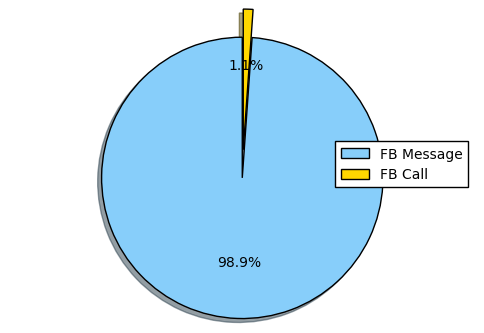

In [8]:
"""Plot the number of messages and calls"""
%matplotlib inline
import matplotlib.pyplot as plt

# The slices will be ordered and plotted counter-clockwise.
labels =  'FB Message', 'FB Call'
sizes = [FM, TO]
colors = ['lightskyblue','gold']
explode = (0, 0.2)  # only "explode" the 2nd slice
#patches, texts = plt.pie(sizes, colors=colors, startangle=90, explode=explode, autopct='%1.1f%%')
#plt.legend(patches, labels, loc="best")
patches, texts,junk=plt.pie(sizes, explode=explode, shadow=True, colors=colors, startangle=90, autopct='%1.1f%%')
plt.legend(patches, labels,loc='center right',
           fontsize=10)
plt.axis('equal')
#plt.figure(figsize=(20,20))
#plt.savefig('fig1.png', dpi = 300)
#plt.close()

In [50]:
# will store your messages into a list
conv1=[list(i) for i in zip(shdt,user,tx,call)]
conv1.sort(key=lambda x: x[0])
conv1=[["Date", "User", "Text","Call"]]+conv1

"""Prepare our data to plot the FB timeline"""
df=pd.DataFrame(conv1[1:],columns=conv1[0])
df=df.sort_values(by='Date');
df1=df[df['Call']=='FB Msg']
df2=df[df['Call']!='FB Msg']
#df2[df2.Call!='FB Msg'].Call=1
table = pd.pivot_table(df1, values=['Call'], index=['Date'], aggfunc='count')
table1 = pd.pivot_table(df2, values=['Call'], index=['Date'], aggfunc='count')
# Count number of days between dates
d0 = dateparser.parse(sorted(list(set(date)))[0]).date()
d1 = dateparser.parse(sorted(list(set(date)))[-1]).date()
delta = d1 - d0  #print delta.days # number of days
idx = pd.date_range(d0, d1)
table.index = pd.DatetimeIndex(table.index)
table.reindex(idx,fill_value=0)
table1.index = pd.DatetimeIndex(table1.index)
table1.reindex(idx,fill_value=0)
print "Now we can plot our daily calls and messages"

Now we can plot our daily calls and messages


In [51]:
"""Plots the timeline of our messages on y axis while calls will be on the secondary y axis"""
%matplotlib inline
import matplotlib.pyplot as plt
#plt.show()
fig, ax = plt.subplots()
table.reset_index().plot(x='Date', y='Call', label='MSG',ax=ax)
table1.reset_index().plot(x='Date', y='Call',ax=ax, secondary_y=True)
lines = ax.get_lines() + ax.right_ax.get_lines()
labs = [l.get_label() for l in lines]
ax.legend(lines, labs, loc='upper left')

In [ ]:
# Exports all conversations sorted by date
conv=[list(i) for i in zip(date,user,tx,call)]
conv.sort(key=lambda x: x[0])
conv=[["Date", "User", "Text","Call"]]+conv
import csv
with open('FB.csv', 'wb') as f:
    writer = csv.writer(f)
    writer.writerows(conv)